In [1]:
import os, sys
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
# Load from CSV file
data_filename = "../Big-5-Data/data.csv"
main_df = pd.read_csv(data_filename, sep='\t')
main_df.head()

,race,age,engnat,gender,hand,source,country,E1,E2,E3,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,3,53,1,1,1,1,US,4,2,5,...,4,1,3,1,5,1,4,2,5,5
1,13,46,1,2,1,1,US,2,2,3,...,3,3,3,3,2,3,3,1,3,2
2,1,14,2,2,1,1,PK,5,1,1,...,4,5,5,1,5,1,5,5,5,5
3,3,19,2,2,1,1,RO,2,5,2,...,4,3,5,2,4,2,5,2,5,5
4,11,25,2,2,1,2,US,3,1,3,...,3,1,1,1,3,1,3,1,5,3


In [3]:
# Copy the personality data.
big5_df = main_df.iloc[:, 7:].copy()
# Average 10 extraversion answers, neuroticism answers, etc. and put averages into a new table.
big5_df = big5_df.groupby(np.arange(len(big5_df.columns))//10, axis=1).mean()
# Rename columns that got lost in averaging
big5_df.columns = ['E', 'N', 'A', 'C', 'O']
# We now have averages of the big 5 personality traits and appropriate scores for each
big5_df.head()

,E,N,A,C,O
0,3.2,1.9,3.2,3.1,3.1
1,2.8,2.9,3.1,2.8,2.6
2,2.9,4.6,3.8,3.3,4.1
3,3.6,4.3,3.7,3.4,3.7
4,2.6,3.2,4.0,2.6,2.2


In [4]:
# Get the gender column (which will be our target)
gender = main_df.gender
# Split and shuffle the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(big5_df, gender, stratify=gender, random_state=42)

In [5]:
# A logistic regression model used for simple classification. We'll use an L1 regularization because 
#  we want to know what to know which features are driving the prediction (clear box instead of black box).
#  The "saga" solver can handle L2 regularization and and is faster for large datasets. 
logreg = LogisticRegression(penalty="l1", C=1, solver='liblinear').fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.626
Test set score: 0.627


In [6]:
# The R-squared is poor. But since our training score is relatively close to our test score, we know that 
#  we're probably underfitting. We can decrease the strength of regularization with the C parameter to try 
#  and make our model more accurate.

In [7]:
logreg_attempt_2 = LogisticRegression(penalty="l1", C=100, solver='liblinear').fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg_attempt_2.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg_attempt_2.score(X_test, y_test)))

Training set score: 0.626
Test set score: 0.628


In [8]:
# Not much of an effect. For a sanity check, let's make sure that the parameter is at least having some effect
#  by lowering the value of C.
logreg_attempt_3 = LogisticRegression(penalty="l1", C=0.01, solver='liblinear').fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg_attempt_3.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg_attempt_3.score(X_test, y_test)))

Training set score: 0.620
Test set score: 0.619


In [9]:
# We can see that the change of C has an effect when we lower it, and a bad one! I don't think we'll do much better
#  with this logistic regression model.
#  Now let's see what's driving the prediction:
print(logreg.coef_)

[[-0.56893341 -0.91497448 -0.74192992  0.          0.        ]
 [ 0.57754677 -0.41155548 -0.43954702 -0.26945119  0.52702022]
 [-0.5592982   0.40172562  0.45307966  0.26153711 -0.54679189]
 [-0.64570648  0.43756457 -0.6506532   0.          0.67160537]]


In [10]:
# That's weird. Because it's a simple linear model with 2 classes (2 genders), it should have just one set 
#  of coefficients (and we have 4). But if we look closer at a description of the data we can see:
#  "gender	Chosen from a drop down menu. 1=Male, 2=Female, 3=Other (0=missed)"
#  Aha! There are actually 4 different classes, making this a multiclass classification problem. The algorithm
#  used the "one-vs-rest" approach, attempting to distinguish each class from the rest using 4 different lines.

In [11]:
# This is good, because now we can see what variables are driving the prediction. But first, let's make sure our 
#  predictions make sense. The big 5 trait correlations with gender tends to change across different studies. 
#  But most consistently, women rate higher in Nueroticism (N). So let's test predictions for a high and low N
#  individual who is otherwise average:
print("Prediction for high and N: ", logreg.predict(np.array([2.5,5,2.5,2.5,2.5]).reshape(1,-1)))
# And then a prediction for someone average in other features but low in the 2 that matter:
print("Prediction for low in N: ", logreg.predict(np.array([2.5,1,2.5,2.5,2.5]).reshape(1,-1)))

Prediction for high and N:  [2]
Prediction for low in N:  [1]


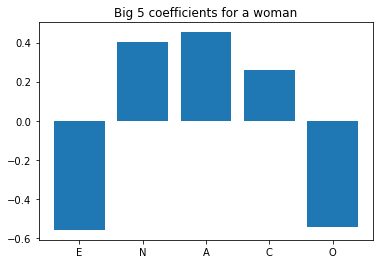

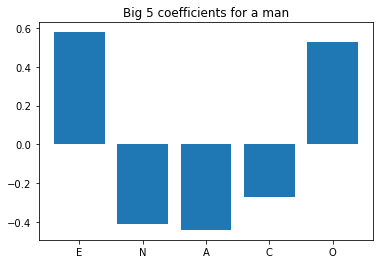

In [12]:
# Success! The person who was higher in N was predicted to be a woman, and a the person lower in N was predicted to 
# be a man.
# Now let's see what the coefficient factors look like for a woman, 
plt.bar(['E','N','A','C','O'], logreg.coef_[2])
plt.title('Big 5 coefficients for a woman')
plt.show()
plt.bar(['E','N','A','C','O'], logreg.coef_[1])
plt.title('Big 5 coefficients for a man')
plt.show()

In [13]:
# Generally, research varies on gender differences within the big 5. But it well-agreed that women are generally 
#  higher in Neuroticism, so it makes sense that our model has a positive coefficient for women. 
# Anyone interested in the reserach on gender differences between men and women can checkout this section of 
#  Wikipedia: https://en.wikipedia.org/wiki/Big_Five_personality_traits#Biological_and_developmental_factors